In [ ]:
import numpy as np
from spec_id import Get_flux,Scale_model,Identify_stack,Analyze_specz,Highest_likelihood_model_galaxy,Analyze_Stack_avgage_cont_feat_gal_age_correct
import matplotlib.pyplot as plt
from matplotlib import gridspec
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [ ]:
ids,speclist,lmass,rshift,rad,sig,comp=np.array(Readfile('masslist_mar22.dat',is_float=False))
lmass,rshift,rad,sig,comp=np.array([lmass,rshift,rad,sig,comp]).astype(float)

gid, rfv, iracm =Readfile('galaxy_mags.dat', is_float=False)
rfv, iracm=np.array([rfv, iracm]).astype(float)

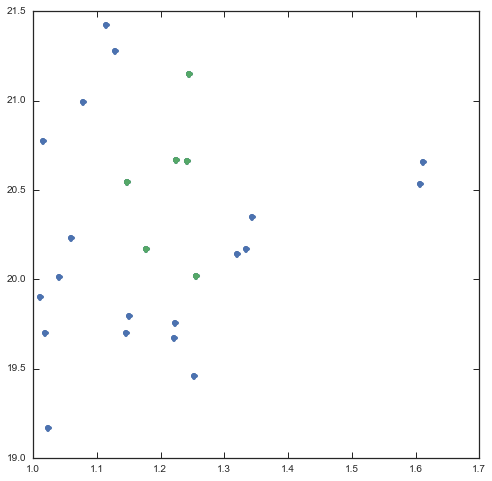

['n14713' 'n21427' 'n32566' 'n37686' 's38785' 's39805']
[ 20.66767488  20.66066557  20.54373062  20.01829509  20.16868119
  21.15045636]


In [11]:
%matplotlib inline

IDp=[]
for i in range(len(ids)):
    if 1.14 <= rshift[i] <= 1.3 and 20 <=iracm[i]:
        IDp.append(i)

plt.figure(figsize=[8,8])
plt.plot(rshift,iracm,'o')
plt.plot(rshift[IDp],iracm[IDp],'o')
plt.show()
plt.close()

print ids[IDp]
print iracm[IDp]

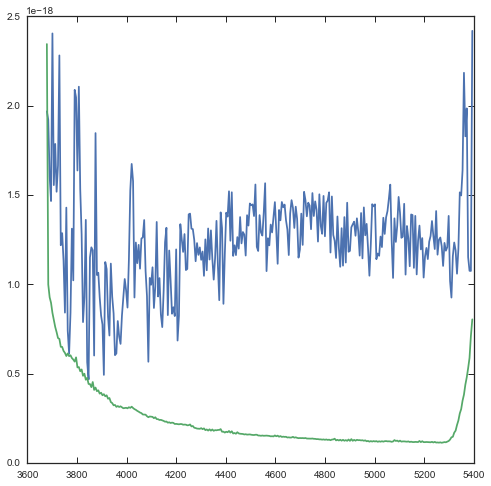

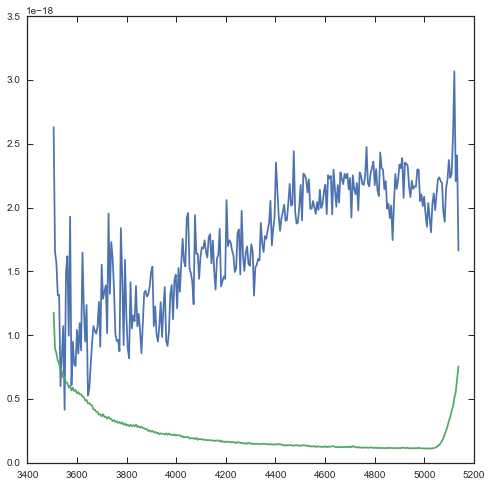

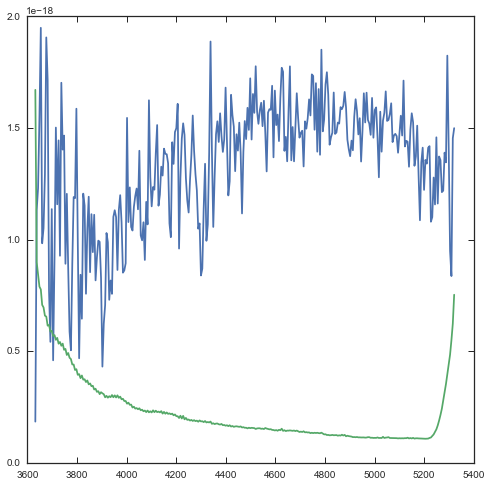

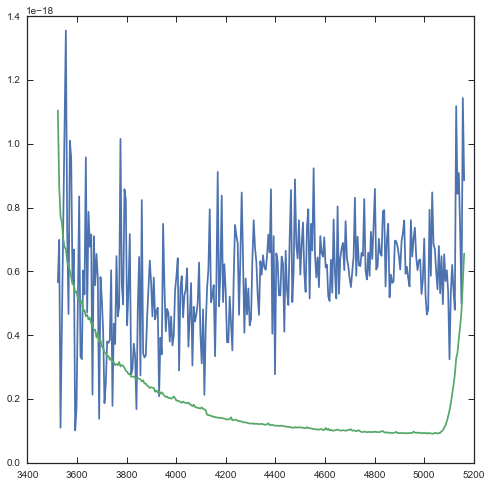

In [15]:
good_gals=['n32566', 'n37686', 's38785', 's39805']
field=['GN5','GN1','GS3','GS3']
idx=[U for U in range(len(ids)) if ids[U] in good_gals]
for i in range(len(idx)):
    wv,fl,er=np.load(speclist[idx][i])
    wv/=(1+rshift[idx][i])
    plt.figure(figsize=[8,8])
    plt.plot(wv,fl)
    plt.plot(wv,er)
    plt.show()
    plt.close()

['/Users/Vince.ec/Clear_data/extractions_nov_22/GN2/GDN21-21-345-G102_21156.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GN2/GDN25-25-195-G102_21156.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GN2/GN2-51-345-G102_21156.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GN2/GN2-52-309-G102_21156.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GN2/GN2-53-309-G102_21156.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GN2/GN2-55-022-G102_21156.1D.fits']
7950.70994986 11342.6770219


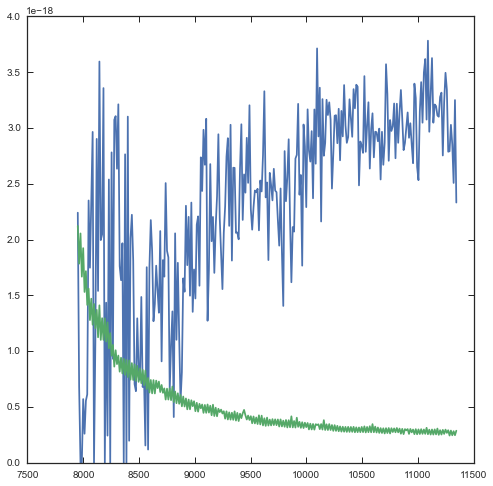

7962.30650646 11345.2529635


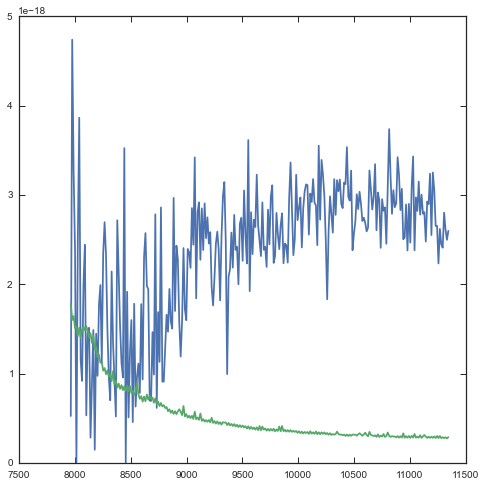

7950.41644067 11337.8231966


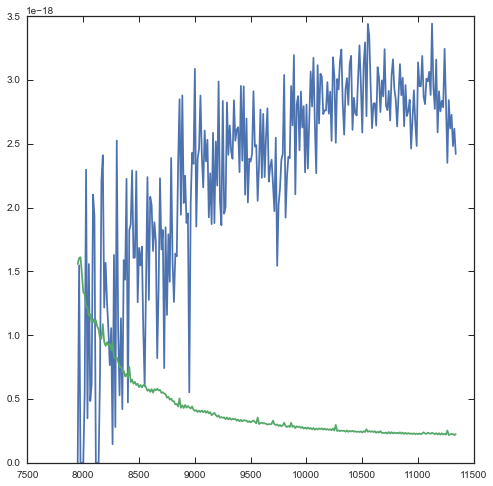

7962.05771917 11341.1428731


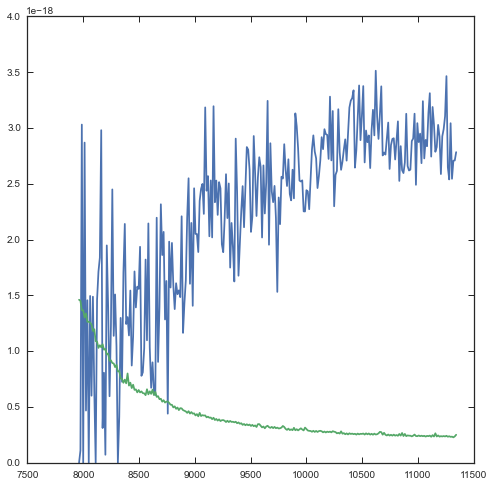

7962.05771917 11341.1428731


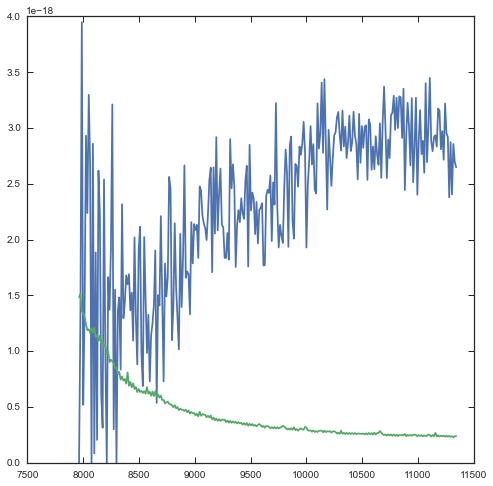

7962.42514787 11343.4828964


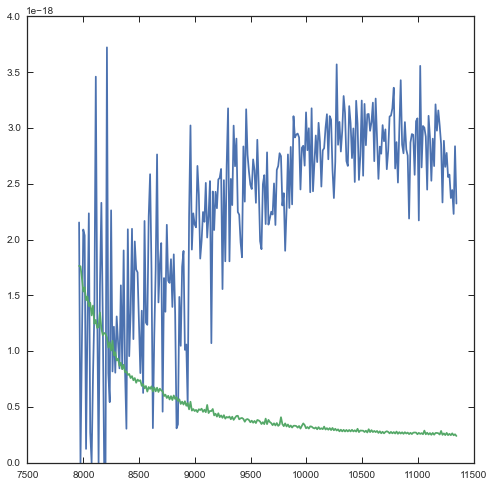

In [4]:
%matplotlib inline

gallist=glob('/Users/Vince.ec/Clear_data/extractions_nov_22/GN2/*21156*1D*')[:-1]

print gallist


for i in range(len(gallist)):
    # 
    wv,fl,er=Get_flux(gallist[i])
    print wv[0],wv[-1]
    plt.figure(figsize=[8,8])
    plt.plot(wv,fl)
    plt.plot(wv,er)
    plt.show()
    plt.close()

In [24]:
def Stack_galaxy(spec, wv):
    flgrid = np.zeros([len(spec), len(wv)])
    errgrid = np.zeros([len(spec), len(wv)])
    for i in range(len(spec)):
        wave, flux, error = Get_flux(spec[i])

        # IDW = []
        # for ii in range(len(wave)):
        #     if 7950 < wave[ii] < 11300:
        #         IDW.append(ii)
        # 
        # wave, flux, error = np.array([wave[IDW], flux[IDW], error[IDW]])
        
        mask = np.array([wave[0] < U < wave[-1] for U in wv])
        ifl = interp1d(wave, flux)
        ier = interp1d(wave, error)
        flgrid[i][mask] = ifl(wv[mask])
        errgrid[i][mask] = ier(wv[mask])
    ################

    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / np.sum(weigrid[i])
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################

    IDX = [U for U in range(len(wv)) if stack[U] > 0]

    return wv[IDX], stack[IDX], err[IDX]

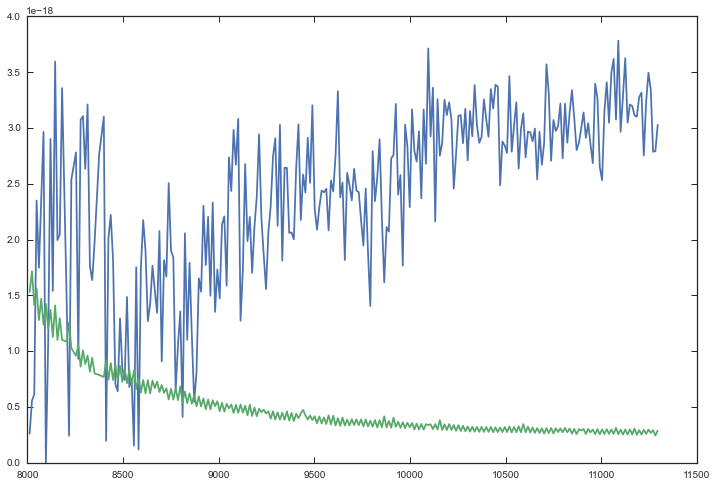

In [13]:
inwv,fl,er=Get_flux(gallist[0])
IDwv=[]
for i in range(len(inwv)):
    if 8000 <= inwv[i] <= 11300:
        IDwv.append(i)

wv,fl,er=Stack_galaxy(np.array(gallist)[0:1],np.array(inwv)[IDwv])

# np.save('one_orbit_stack',[wv,fl,er])

plt.figure(figsize=[12,8])
plt.plot(wv,fl)
plt.plot(wv,er)
plt.show()
plt.close()

In [40]:
good_gals=['n32566', 'n37686', 's38785', 's39805']
field=['GN5','GN1','GS3','GS3']
stack_sizes=[1,2,4]
omit=['/Users/Vince.ec/Clear_data/extractions_nov_22/GN5/GN5-41-014-G102_32566.1D.fits',
      '/Users/Vince.ec/Clear_data/extractions_nov_22/GN1/GN1-46-173-G102_37686.1D.fits',
      '/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-30-193-G102_38785.1D.fits']
for i in range(len(good_gals)):
    alllist=glob('/Users/Vince.ec/Clear_data/extractions_nov_22/%s/%s*%s*1D*' % (field[i],field[i],good_gals[i][1:]))[:-1]
    # fname,qual=Readfile('spec_stacks_nov29/%s_quality.txt' % good_gals[i],is_float=False)
    gallist=[]
    for ii in range(len(alllist)):
        if alllist[ii] not in omit:
            gallist.append(alllist[ii])
    for ii in stack_sizes:
        ngallist=gallist[0:ii]
        inwv,fl,er=Get_flux(ngallist[0])
        IDwv=[]
        for iii in range(len(inwv)):
            if 8000 <= inwv[iii] <= 11300:
                IDwv.append(iii)

        wv,fl,er=Stack_galaxy(ngallist,np.array(inwv)[IDwv])

        np.save('rshift_test/%s_%s_orbit_stack' % (good_gals[i] , ii),[wv,fl,er])

['/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-30-193-G102_38785.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-31-193-G102_38785.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-32-173-G102_38785.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-33-173-G102_38785.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-34-216-G102_38785.1D.fits', '/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-35-216-G102_38785.1D.fits']
/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-31-193-G102_38785.1D.fits


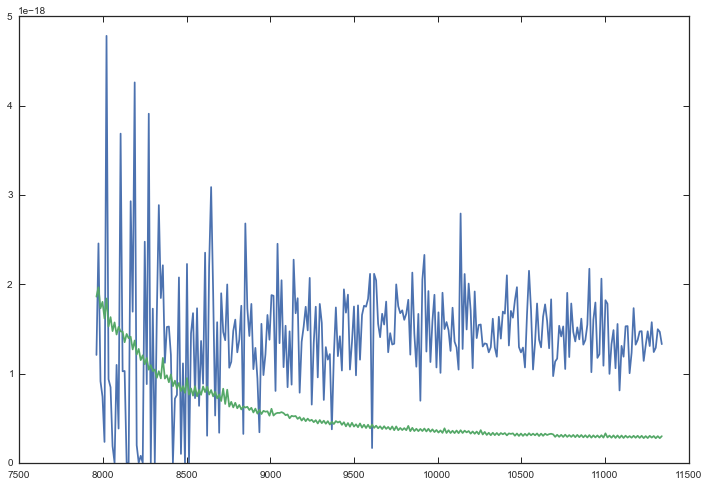

/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-32-173-G102_38785.1D.fits


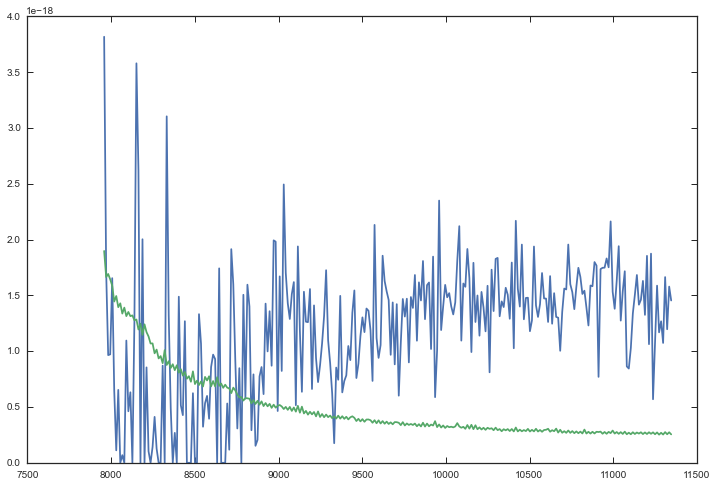

/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-33-173-G102_38785.1D.fits


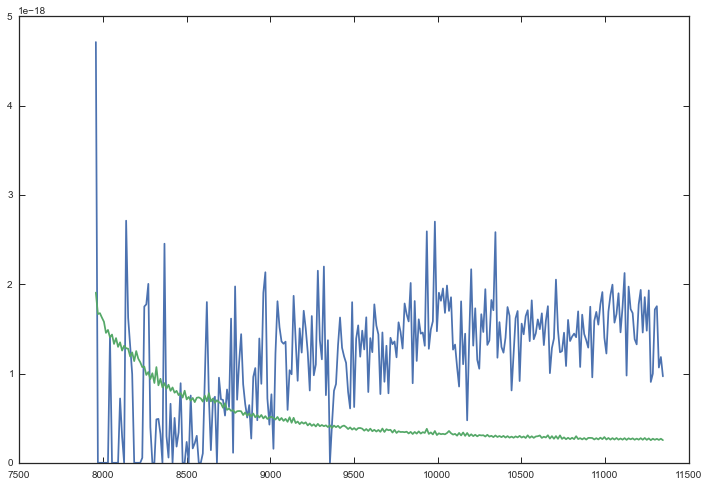

/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-34-216-G102_38785.1D.fits


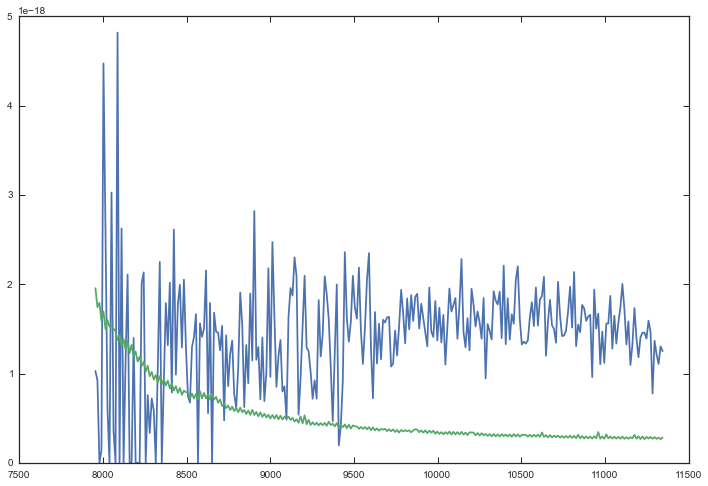

/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-35-216-G102_38785.1D.fits


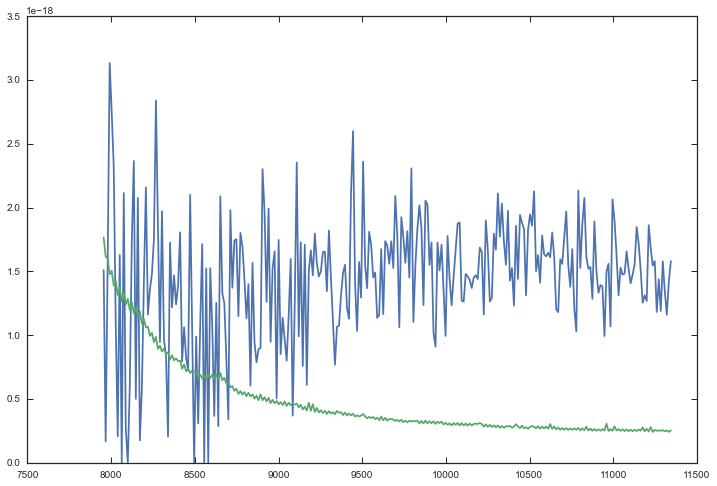

In [38]:
good_gals=['n32566', 'n37686', 's38785', 's39805']
field=['GN5','GN1','GS3','GS3']
stack_sizes=[1,2,4]

omit=['/Users/Vince.ec/Clear_data/extractions_nov_22/GN5/GN5-41-014-G102_32566.1D.fits',
      '/Users/Vince.ec/Clear_data/extractions_nov_22/GN1/GN1-46-173-G102_37686.1D.fits',
      '/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3-30-193-G102_38785.1D.fits']

gallist=glob('/Users/Vince.ec/Clear_data/extractions_nov_22/GS3/GS3*38785*1D*')[:-1]
print gallist
for ii in range(len(gallist)):
    if gallist[ii] not in omit:
        wv,fl,er=Get_flux(gallist[ii])
        print gallist[ii]
        
        plt.figure(figsize=[12,8])
        plt.plot(wv,fl)
        plt.plot(wv,er)
        plt.show()
        plt.close()  
        
    # for ii in stack_sizes:
    #     ngallist=gallist[0:ii]
    #     inwv,fl,er=Get_flux(ngallist[0])
    #     IDwv=[]
    #     for iii in range(len(inwv)):
    #         if 8000 <= inwv[iii] <= 11300:
    #             IDwv.append(iii)

        # wv,fl,er=Stack_galaxy(ngallist,np.array(inwv)[IDwv])

        # np.save('rshift_test/%s_%s_orbit_stack' % (good_gals[i] , ii),[wv,fl,er])

rshift_test/n32566_1_orbit_stack.npy


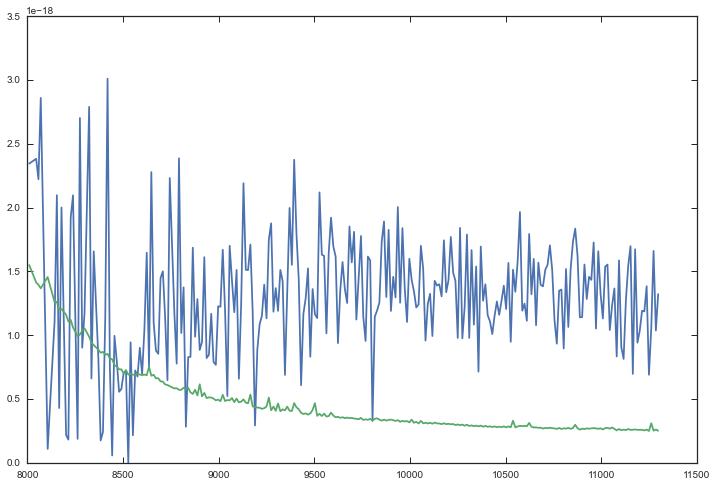

rshift_test/n32566_2_orbit_stack.npy


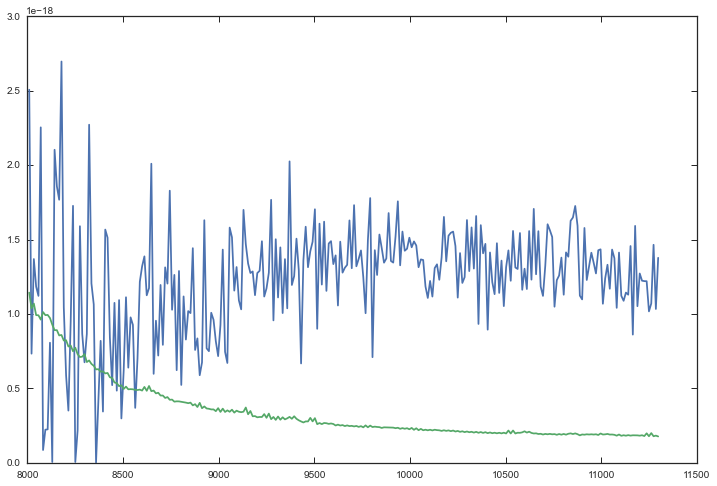

rshift_test/n32566_4_orbit_stack.npy


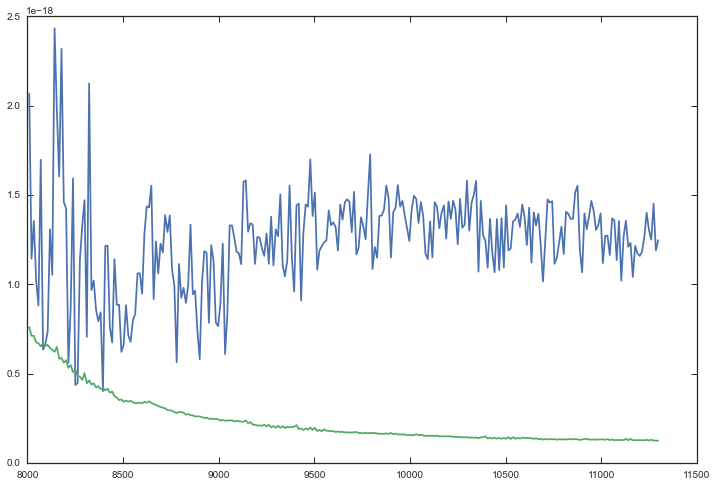

rshift_test/n37686_1_orbit_stack.npy


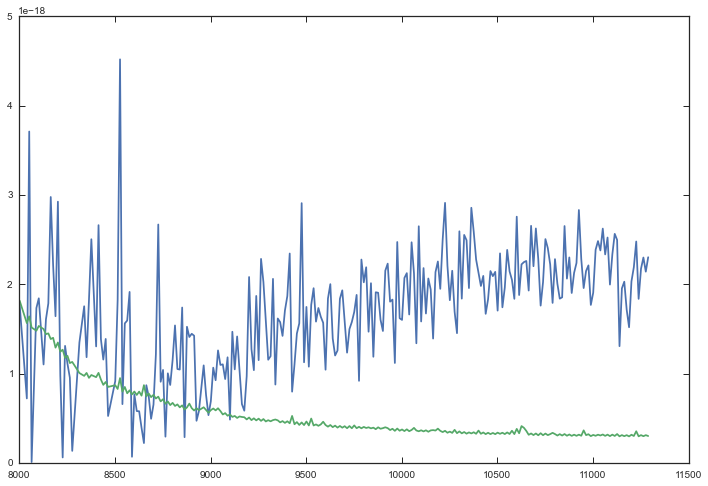

rshift_test/n37686_2_orbit_stack.npy


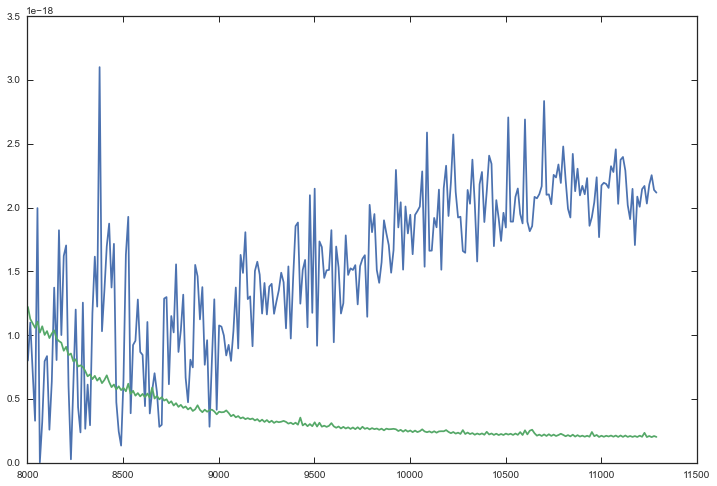

rshift_test/n37686_4_orbit_stack.npy


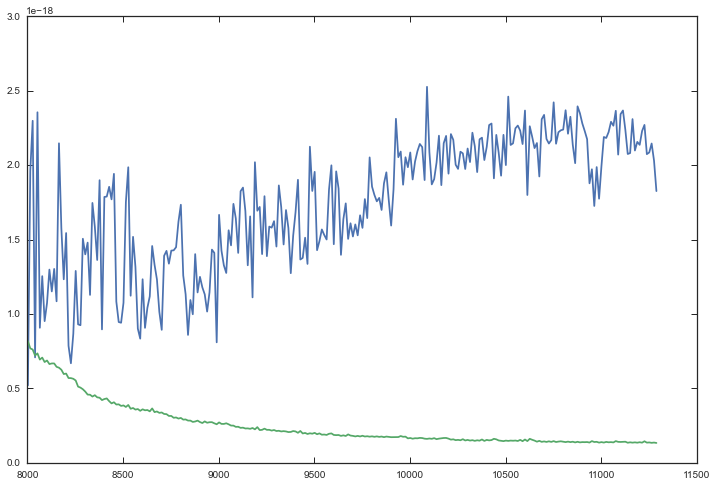

rshift_test/s38785_1_orbit_stack.npy


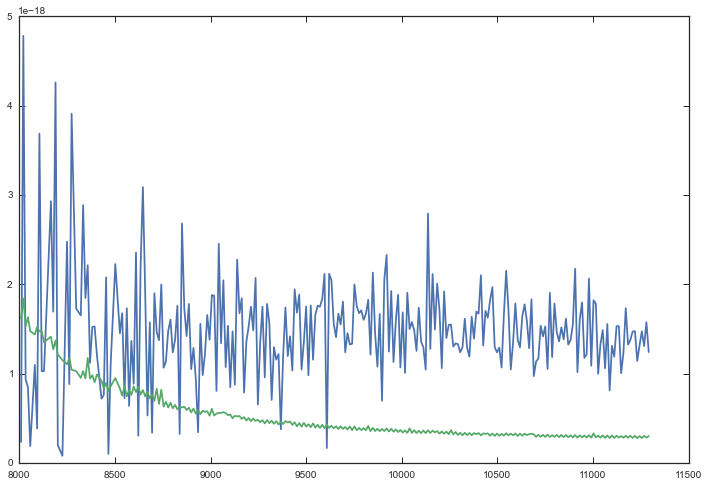

rshift_test/s38785_2_orbit_stack.npy


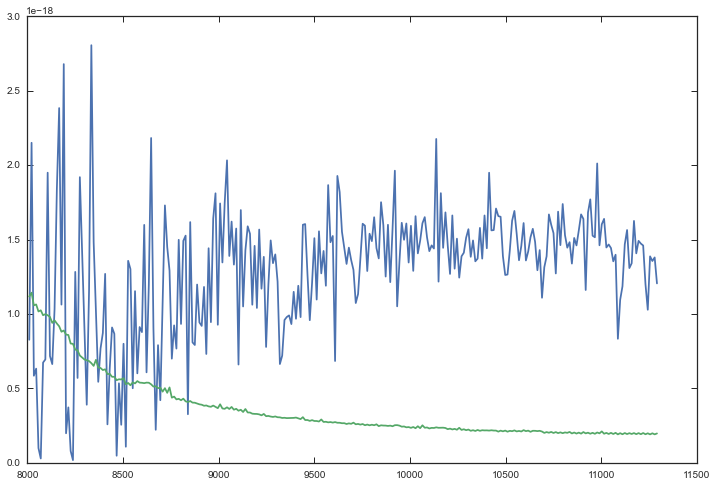

rshift_test/s38785_4_orbit_stack.npy


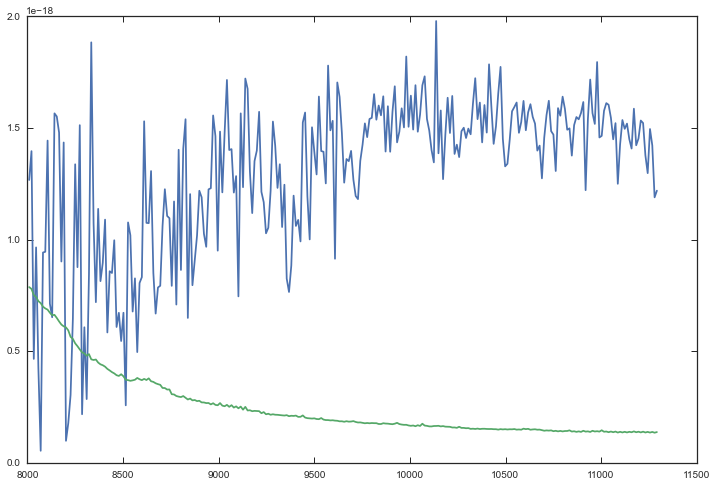

rshift_test/s39805_1_orbit_stack.npy


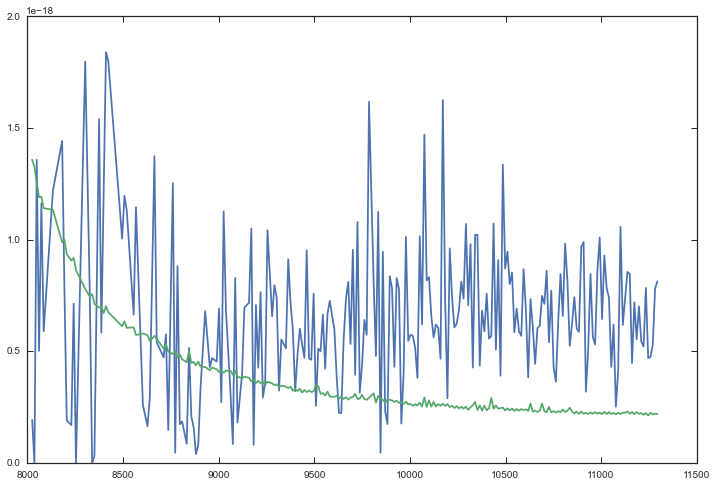

rshift_test/s39805_2_orbit_stack.npy


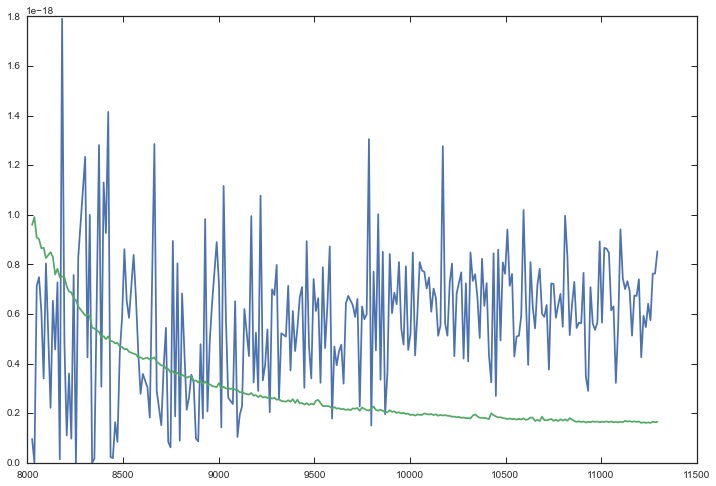

rshift_test/s39805_4_orbit_stack.npy


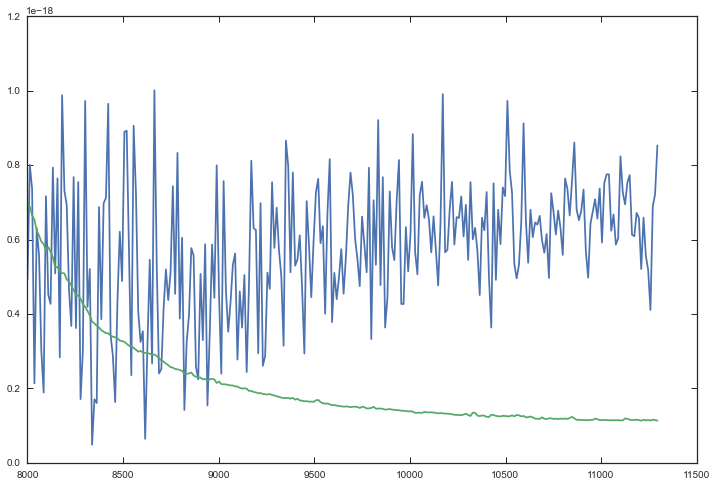

In [41]:
glist=glob('rshift_test/*')

for i in range(len(glist)):
    wv,fl,er=np.load(glist[i])
    
    print glist[i]
    plt.figure(figsize=[12,8])
    plt.plot(wv,fl)
    plt.plot(wv,er)
    plt.show()
    plt.close()

In [5]:
def Specz_fit(galaxy ,spec, rshift, metal, A, name):
    wv,fl,err=np.load(spec)

    #############Prep output file###############
    chifile='rshift_dat/%s_chidata.fits' % name
    prihdr = fits.Header()
    prihdu = fits.PrimaryHDU(header=prihdr)
    hdulist = fits.HDUList(prihdu)

    #############Get list of models to fit againts##############
    filepath = '../../../fsps_models_for_fit/rshift_models/'
    modellist = []
    for i in range(len(metal)):
        m = []
        for ii in range(len(A)):
            a = []
            for iii in range(len(rshift)):
                a.append(filepath + 'm%s_a%s_t0_z%s_%s_model.npy' % (metal[i], A[ii], rshift[iii],galaxy))
            m.append(a)
        modellist.append(m)

    ##############Create chigrid and add to file#################
    chigrid=np.zeros([len(metal),len(A),len(rshift)])
    for i in range(len(metal)):
        for ii in range(len(A)):
            for iii in range(len(rshift)):
                mwv,mf= np.load(modellist[i][ii][iii])
                imf=interp1d(mwv,mf)(wv)
                C=Scale_model(fl,err,imf)
                chigrid[i][ii][iii]=Identify_stack(fl,err,imf*C)
        inputgrid = np.array(chigrid[i])
        spc ='metal_%s' % metal[i]
        mchi = fits.ImageHDU(data=inputgrid, name=spc)
        hdulist.append(mchi)
    ################Write chigrid file###############

    hdulist.writeto(chifile)

    Analyze_specz(chifile,rshift,metal,A,name)

    print 'Done!'

    return

In [8]:
good_gals=['n32566', 'n37686', 's38785', 's39805']
stack_sizes=[1,2,4]

metal = np.array([0.003, 0.006, 0.009, 0.012, 0.015, 0.019, 0.024])
age = [0.5,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5]
zshift = np.arange(1., 1.51, 0.01)
for i in range(len(good_gals)):
    for ii in range(len(stack_sizes)):
        Specz_fit(good_gals[i],'rshift_test/%s_%s_orbit_stack.npy' % (good_gals[i],stack_sizes[ii]), zshift, metal, age,
              '%s_%s_orbit_fit'% (good_gals[i],stack_sizes[ii]))

Best fit specz is 1.15
Done!
Best fit specz is 1.15


Done!
Best fit specz is 1.15


Done!
Best fit specz is 1.3


Done!
Best fit specz is 1.27


Done!
Best fit specz is 1.25


Done!
Best fit specz is 1.06


Done!
Best fit specz is 1.17


Done!
Best fit specz is 1.18


Done!
Best fit specz is 1.24


Done!
Best fit specz is 1.24


Done!
Best fit specz is 1.24


Done!


In [6]:
chi=[]

wv,fl,er=np.load('two_orbit_stack.npy')

for i in range(len(zshift)):
    mwv,mf= np.load('../../../fsps_models_for_fit/rshift_models/m0.019_a2.0_t0_z%s_n21156_model.npy' % zshift[i])
    imf=interp1d(mwv,mf)(wv)
    C=Scale_model(fl,er,imf)
    chi.append(Identify_stack(fl,er,imf*C))

In [7]:
pma=np.exp(-np.array(chi)/2)
Cma=np.trapz(pma,zshift)
pma/=Cma

In [5]:
gidx=[U for U in range(len(ids)) if ids[U] in good_gals]

print ids[gidx]
print good_gals

['n32566' 'n37686' 's38785' 's39805']
['n32566', 'n37686', 's38785', 's39805']


In [ ]:
%matplotlib inline
good_gals=['n32566', 'n37686', 's38785', 's39805']
xlims=[[1.0,1.2],[1.15,1.35],[1.0,1.2],[1.0,1.35]]

for i in range(len(good_gals)):
    z1,p1=Readfile('rshift_test/%s_1_orbit_fit_Pofz.dat' % good_gals[i])
    z2,p2=Readfile('rshift_test/%s_2_orbit_fit_Pofz.dat' % good_gals[i])
    z4,p4=Readfile('rshift_test/%s_4_orbit_fit_Pofz.dat' % good_gals[i])

    plt.figure(figsize=[8,8])
    plt.plot(z1,p1,label='one orbit')
    plt.plot(z2,p2,label='two orbit')
    plt.plot(z4,p4,label='four orbit')
    plt.axvline(rshift[gidx][i],linestyle='--',alpha=.5,label='specz = %s' % rshift[gidx][i])
    plt.title('Irac mag = %s ' % np.round(iracm[gidx][i],2))    
    plt.legend(loc=2,fontsize=15)
    plt.xlim(xlims[i][0],xlims[i][1])
    plt.xlabel('Redshift',fontsize=20)
    plt.ylabel('P(z)',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.minorticks_on()
    # plt.show()
    plt.savefig('../important_plots/%s_rshift_test.png' % good_gals[i])
    plt.close()

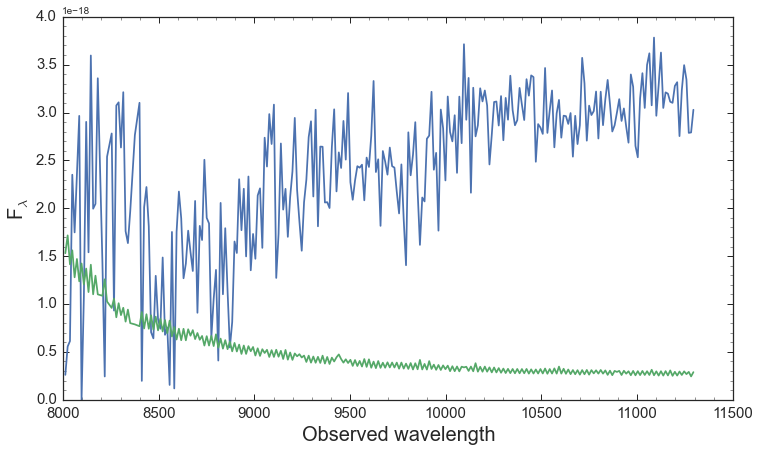

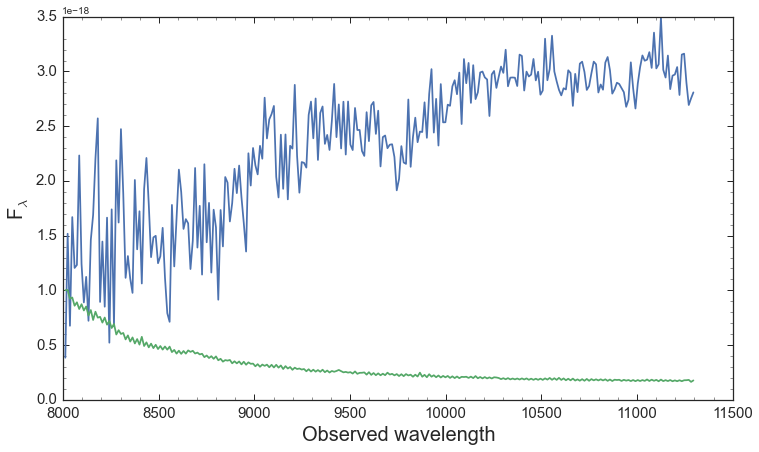

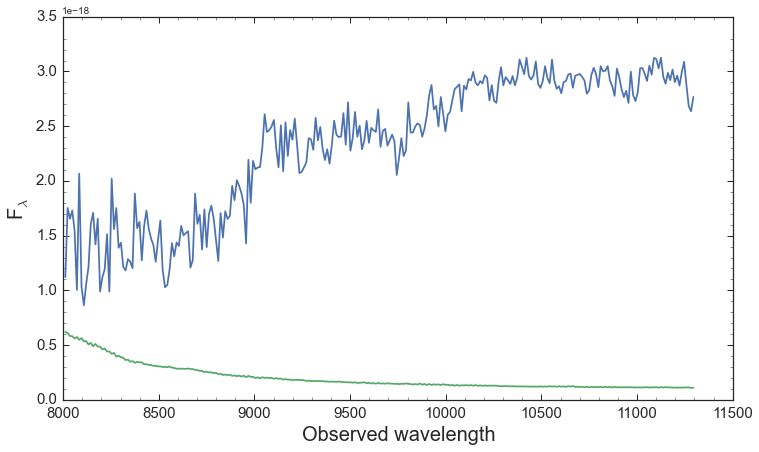

In [20]:
nm=['one','two','four']
for i in range(len(nm)):
    wv,fl,er=np.load('%s_orbit_stack.npy' % nm[i])
    plt.figure(figsize=[12,8])
    plt.plot(wv,fl)
    plt.plot(wv,er)
    plt.xlabel('Observed wavelength',fontsize=20)
    plt.ylabel('F$_\lambda$',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.minorticks_on()
    plt.show()
    plt.close()

In [ ]:
def Redshift_confidence(p, y):
    NP = interp1d(y, p)
    x = np.linspace(y[0], y[-1], 500)

    lerr = 0
    herr = 0
    pmean = 0

    for i in range(len(x)):
        e = np.trapz(NP(x[0:i + 1]), x[0:i + 1])
        if lerr == 0:
            if e >= .025:
                lerr = x[i]    
        if pmean == 0:
            if e >=.5:
                pmean = x[i]
        if herr == 0:
            if e >= .975:
                herr = x[i]
                break

    dz=herr-lerr

    return dz/(1+pmean)

0.0323447562169
n21427
0.0344902457832


s39805
0.0498531479369


s48631


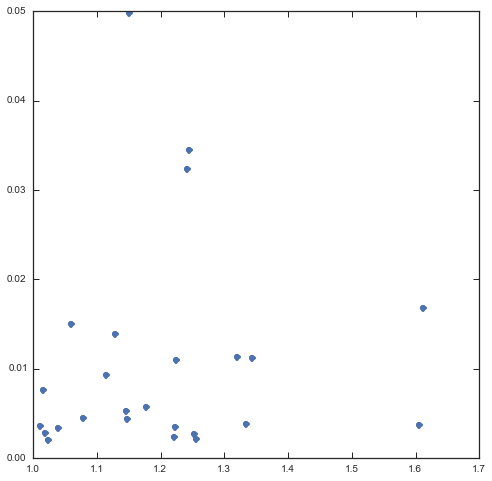

In [31]:
confidence = np.zeros(len(ids))

for i in range(len(ids)):
    zspec,Pzs=Readfile('rshift_dat/%s_specz_Pofz.dat' % ids[i])
    confidence[i]=Redshift_confidence(Pzs,zspec)
    if confidence[i] > .02:
        print confidence[i]
        print ids[i]
    
plt.figure(figsize=[8,8])
plt.plot(rshift,confidence,'o')
plt.show()
plt.close()

0.0244488977956
1.22660921844
0.0109803272137


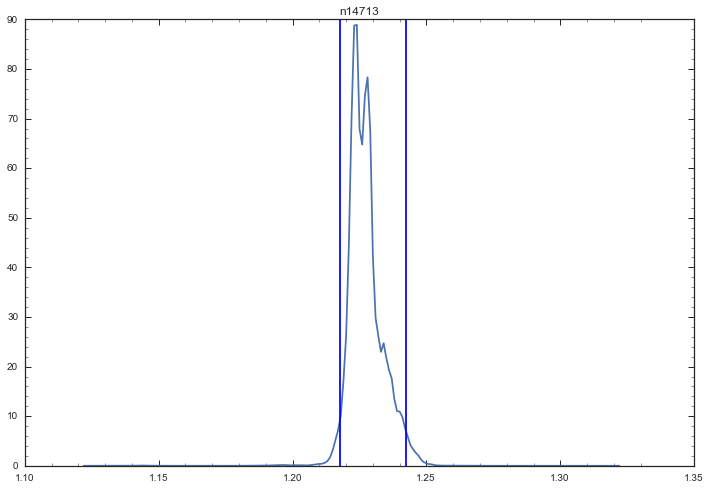

In [24]:
%matplotlib inline

# for i in range(len(ids)):
#     zspec,Pzs=Readfile('rshift_dat/%s_specz_Pofz.dat' % ids[i])
# 
#     lerr,herr=Two_sig(Pzs,zspec)
#     
#     plt.figure(figsize=[12,8])
#     plt.plot(zspec,Pzs)
#     plt.axvline(lerr)
#     plt.axvline(herr)
#     plt.title(ids[i])
#     plt.minorticks_on()
#     plt.show()
#     plt.close()
    
zspec,Pzs=Readfile('rshift_dat/%s_specz_Pofz.dat' % ids[0])

lerr,herr=Two_sig(Pzs,zspec)

plt.figure(figsize=[12,8])
plt.plot(zspec,Pzs)

plt.title(ids[0])
plt.minorticks_on()
plt.show()
plt.close()

1.0


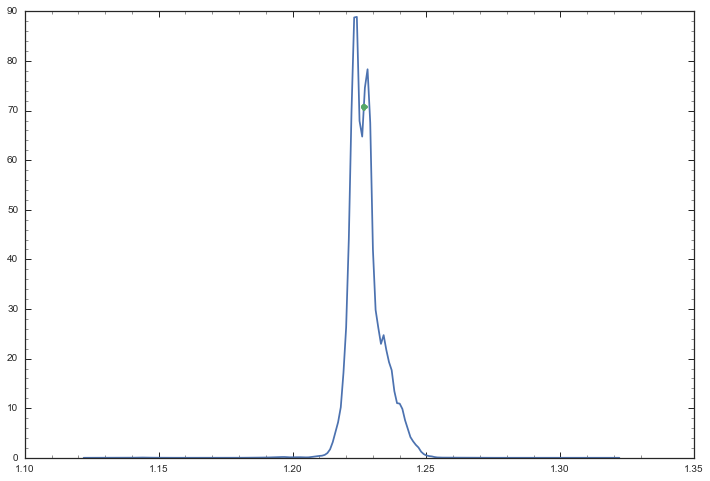

In [44]:
zspec,Pzs=Readfile('rshift_dat/%s_specz_Pofz.dat' % ids[0])

iP = interp1d(zspec,Pzs)
iz = np.linspace(zspec[0], zspec[-1], 500)

pmean = 0
zmean = 0

print np.trapz(Pzs,zspec)

for i in range(len(iz)):
    e = np.trapz(iP(iz[0:i + 1]), iz[0:i + 1]) 
    if pmean == 0:
        if e >=.5:
            pmean = iP(iz)[i]
            zmean = iz[i]
            break


plt.figure(figsize=[12,8])
plt.plot(zspec,Pzs)
plt.plot(zmean,pmean,'o')
plt.minorticks_on()
plt.show()
plt.close()

In [8]:
%matplotlib inline

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]

for i in range(len(ids)):
    zspec,Pzs=Readfile('rshift_dat/%s_specz_Pofz.dat' % ids[i])
    chizp,zphot=Readfile('Pofz/%s_pofz.dat' % ids[i])
    Pzp=np.exp(-chizp/2)
    Cp=np.trapz(Pzp,zphot)
    Pzp/=Cp
    
    wv,fl,er=np.load('spec_stacks_jan24/%s_stack.npy' % ids[i])
    
    Pr, bfage, bfmetal= Analyze_Stack_avgage_cont_feat_gal_age_correct('chidat/%s_apr6_galfit_cont_chidata.fits' % ids[i],
                                                                           'chidat/%s_apr6_galfit_feat_chidata.fits' % ids[i],
                                                                            rshift[i],np.array(tau),metal,age)    
            
    wv,fl,er=np.array([wv[wv<11100],fl[wv<11100],er[wv<11100]])
    if ids[i] == 'n21427':
        IDx=[U for U in range(len(wv)) if 8550 < wv[U]]
        wv,fl,er=np.array([wv[IDx],fl[IDx],er[IDx]])
    if ids[i] == 'n37686':
        IDx=[U for U in range(len(wv)) if 7900 < wv[U]]
        wv,fl,er=np.array([wv[IDx],fl[IDx],er[IDx]])
    if ids[i] == 's42221':
        IDx=[U for U in range(len(wv)) if 7950 < wv[U]]
        wv,fl,er=np.array([wv[IDx],fl[IDx],er[IDx]])
    if ids[i] == 's46066':
        IDx=[U for U in range(len(wv)) if wv[U] < 10600]
        wv,fl,er=np.array([wv[IDx],fl[IDx],er[IDx]])
    
    bfm,bfa,bft=Highest_likelihood_model_galaxy(ids[i],rshift[i],bfmetal,bfage,tau)
    mwv,mfl=np.load('../../../fsps_models_for_fit/galaxy_models/m%s_a%s_t%s_z%s_%s_model.npy' % (bfm,bfa, bft, rshift[i],ids[i]))
    imfl=interp1d(mwv,mfl)(wv)
    C=Scale_model(fl,er,imfl)
    pz_shift=zphot[np.argmax(Pzp)]
    
    minlim=min(fl[1:]-er[1:])
    maxlim=max(fl[1:]+er[1:])
    
    gs=gridspec.GridSpec(2,1,height_ratios=[1,1])

    plt.figure(figsize=[16,12])
    plt.subplot(gs[0])    
    plt.plot(zspec,Pzs,'r',label='P(specz)')
    plt.plot(zphot,Pzp,label='P(specz)')
    plt.xlim(.9,2)
    plt.title(ids[i],fontsize=15)
    plt.legend(fontsize=15)
    plt.minorticks_on()
    plt.xlim(.9,1.75)
       
    plt.subplot(gs[1])    
    plt.errorbar(wv,fl,er,color='k',alpha=.25,fmt='o')
    plt.plot(wv,imfl*C,'r',label='specz=%s' % rshift[i])
    plt.plot(wv*((1+pz_shift)/(1+rshift[i])),imfl*C,label='photz=%s' % pz_shift)
    plt.legend(loc=4,fontsize=15)
    plt.xlim(wv[0],wv[-1])
    plt.ylim(minlim,maxlim)
    plt.savefig('../important_plots/%s_pz_exam.png' % ids[i])
    plt.close()

Best fit model is 3.6 Gyr and 0.03 Z
Best fit model is 5.2 Gyr and 0.021 Z


Best fit model is 3.5 Gyr and 0.006 Z


Best fit model is 4.1 Gyr and 0.03 Z


Best fit model is 4.1 Gyr and 0.004 Z


Best fit model is 3.8 Gyr and 0.015 Z


Best fit model is 2.3 Gyr and 0.024 Z


Best fit model is 4.4 Gyr and 0.008 Z


Best fit model is 1.8 Gyr and 0.022 Z


Best fit model is 4.2 Gyr and 0.004 Z


Best fit model is 2.7 Gyr and 0.027 Z


Best fit model is 4.7 Gyr and 0.024 Z


Best fit model is 4.9 Gyr and 0.018 Z


Best fit model is 4.7 Gyr and 0.008 Z


Best fit model is 4.0 Gyr and 0.016 Z


Best fit model is 3.4 Gyr and 0.03 Z


Best fit model is 3.4 Gyr and 0.005 Z


Best fit model is 3.9 Gyr and 0.013 Z


Best fit model is 1.4 Gyr and 0.015 Z


Best fit model is 3.9 Gyr and 0.03 Z


Best fit model is 4.9 Gyr and 0.024 Z


Best fit model is 4.9 Gyr and 0.003 Z


Best fit model is 4.1 Gyr and 0.029 Z


Best fit model is 4.0 Gyr and 0.004 Z


Best fit model is 3.3 Gyr and 0.015 Z